# CS109A Final Project: Data Analysis 
**Harvard University**<br>
**Fall 2016**<br>
**Authors: Kurt Bullard and Kendrick Vinar**<br>


## Import Packages

In [181]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn import linear_model
from sklearn import discriminant_analysis
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
import StringIO
from sklearn.linear_model import LogisticRegression
import matplotlib
import matplotlib.pyplot as plt


import itertools as it
from sklearn.cross_validation import KFold
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn import svm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## Functions 

Below are all the functions used in the data analysis process. 

In [182]:
#
# functions for splitting data on desired predictor/response
#

def split_on_win(data):
    x = data.iloc[:, :-8]
    y = data.loc[:, 'win_or_loss']
    return x, y

def split_on_pt(data):
    x = data.iloc[:, :-8]
    y = data.loc[:, 'pt_diff']
    return x, y

In [183]:
#
# function that returns data for a given year
#
# Inputs: 
#     matrix - the dataset containing all years (NOTE: should be cleaned)
#     desired_years - a list of integers, e.g., [2004, 2005, 2006]
#
# Outputs:
#     

def get_years(matrix, desired_years):
    return matrix.loc[matrix['Year'].isin(desired_years)]



In [184]:
#preds_2015 = prediction_matrix.loc[prediction_matrix['Year'].isin([2015])]

# Get the No. seed from the total seed 

def clean_prediction_matrix(pred_matrix):   
    # removes 'a' or 'b' appended to play-in teams
    for i in range(0, len(pred_matrix)):
        if (len(pred_matrix.ix[i,"team1spot"]) == 4):
            pred_matrix.ix[i,"team1spot"] = pred_matrix.ix[i,"team1spot"][0:3]
        if (len(pred_matrix.ix[i,"team2spot"]) == 4):
            pred_matrix.ix[i,"team2spot"] = pred_matrix.ix[i,"team2spot"][0:3]
    
    return pred_matrix

#
# Resets index of matrix, needed after taking excerpt from original matrix
#

def reset_index(pred_matrix):
    pred_matrix = pred_matrix.reset_index(drop = True)
    return pred_matrix

In [185]:
#
# Input:
#     df - dataframe containing prediction matrix of a given year (e.g., preds_2015)
#          also, is the result of the get_years function
#
# Output: 
#     d - dictionary mapping team codes (e.g., W13) to a list of predictors 
#

def dictionary_gen (df):
    # first want a new df that only has round 1 results
    # because all 64 teams play in the first round
    rd_1_results = df.loc[df['round'] == 1]
    
    # create an empty list
    the_list = []
    
    for index, row in rd_1_results.iterrows():
        # for each row, appends a tuple of the unique code
        # and the values that correspond to that team
        
        # NOTE: if this shape of the dataframe passed changes
        #       these indicies will be invalid
        the_list.append([row['team1spot'], row.iloc[:13]])
        the_list.append([row['team2spot'], row.iloc[13:26]])
        
    # create a dictionary
    d = dict(the_list)
    
    return d
    
        
    
    

In [186]:
# This function recreates the shape of the original training data for each possible
# tournament matchup, allowing for a trained model to be used to make predictions
#
# Input: 
#     pred_matrix - prediction matrix for a given year (e.g., preds_2015)
#     predictors - dictionary mapping team seeding codes to their predictors
#
# Output: 
#     preds_all_games_final - dataframe containing predictors for each possible matchup



def matchups_matrix(pred_matrix, predictors):
    # creates dataframe to hold all possible seed matchups
    preds_all_games = pd.DataFrame(np.zeros((64**2,2)))

    # creates counter for indexing
    count = 0
    
    # inserts all possible combinations of seeds into preds_all_games
    for i in range(len(predictors.keys())):
        for j in range(len(predictors.keys())):
            preds_all_games.ix[count,0] = predictors.keys()[i]
            preds_all_games.ix[count,1] = predictors.keys()[j]
            count = count + 1
    
    # creates two new dataframes to hold predictors for each team
    favorites = pd.DataFrame(np.zeros((64**2,13)))
    underdogs = pd.DataFrame(np.zeros((64**2,13)))

    # retrieves predictors for the favorites and underdogs
    for i in range(0,64**2):
        favorites.iloc[i,:] = pd.Series(predictors[preds_all_games.iloc[i,0]]).values
        underdogs.iloc[i,:] = pd.Series(predictors[preds_all_games.iloc[i,1]]).values
    
    
    interaction_terms = pd.DataFrame(np.zeros((64**2,3)))
    for i in range(0,64**2):
        interaction_terms.iloc[i,0] = favorites.iloc[i,9] * underdogs.iloc[i,10]
        interaction_terms.iloc[i,1] = underdogs.iloc[i,9] * favorites.iloc[i,10]
        #interaction_terms.iloc[i,2] =  favorites.iloc[i,13] * underdogs.iloc[i,13]    
        interaction_terms.iloc[i,2] = favorites.iloc[i,11] * favorites.iloc[i,11]    
        #interaction_terms.iloc[i,3] = underdogs.iloc[i,14] * underdogs.iloc[i,13]
    # concatenates all dataframes together
    preds_all_games_final = pd.concat([preds_all_games, favorites, underdogs,
                                            interaction_terms], axis=1)
    
    # renames columns
    preds_all_games_final.columns = ["favorite", "underdog",'team1tofor', 'team1drratiofor', 'team1orratiofor', 
'team1pot3ptsfor',
 'team1potftptsfor', 'team1toag' ,
 'team1pot3ptsag' ,'team1potftptsag', 'team1kentempo' ,'team1drank',
 'team1orank',
 'team1seed', 
'team1goodwins', 'team2tofor',
 'team2drratiofor', 'team2orratiofor', 'team2pot3ptsfor' ,'team2potftptsfor',
 'team2toag' ,'team2pot3ptsag',
 'team2potftptsag', 'team2kentempo' ,'team2kenoe', 'team2kende', 
 'team2seed',
 'team2goodwins' , 'team1orank+team2drank',
 'team2orank+team1drank','team1seed+team2seed']

    
    return preds_all_games_final

In [187]:
# create list of seeds to represent bracket shape
seeds = ['W01','W16','W08','W09','W04','W13','W05','W12','W06','W11','W03','W14','W07','W10','W02','W15',
         'X01','X16','X08','X09','X04','X13','X05','X12','X06','X11','X03','X14','X07','X10','X02','X15',
         'Y01','Y16','Y08','Y09','Y04','Y13','Y05','Y12','Y06','Y11','Y03','Y14','Y07','Y10','Y02','Y15',
         'Z01','Z16','Z08','Z09','Z04','Z13','Z05','Z12','Z06','Z11','Z03','Z14','Z07','Z10','Z02','Z15']

#
# Input:
#     seeds - ordered list of tournament seeds
#     pred_matrix - prediction matrix for a single year (e.g., preds_2015)
#
# Output: 
#     df - dataframe containing paired seeding and team names

def seed_and_name(seeds, pred_matrix):
    # creates an empty dataframe to map seeds to the name of the tournament
    df = pd.DataFrame(np.zeros((64,2)))


    df.iloc[:,0] = seeds

    for i in range(64):
        try:
            df.iloc[i,1] = pred_matrix['team1name'][pred_matrix['team1spot']==df.iloc[i,0]].values[0]
        except IndexError:
            df.iloc[i,1] = pred_matrix['team2name'][pred_matrix['team2spot']==df.iloc[i,0]].values[0]
        
    return df

In [188]:

#
#
# Input:
#     pred_matrix - dataframe containing predictors for all possible matchups in a given year,
#                   output of matchups_matrix
#     train_data - predictors on which to train our model, likely over 7 year span
#     test_data - responses on which to train our model
#
# Output: 
#     pred_matrix - returns same dataframe with new column for predicted win probabilities 



def make_predictions_log(pred_matrix, train_data, test_data, c):
    # creates list for holding predictions

    pred_matrix2 = pred_matrix
    
    predictions_list = []
    
    # remove first two columns containing team codes
    # leaves only predictors
    predictors = pred_matrix.iloc[:, 2:]
    
    # create a logistic model
    logistic_model = LogisticRegression(C = c)
    
    # fits model on the datas
    logistic_model.fit(train_data, test_data)
    
    coef_matrix = logistic_model.coef_
    
    pred_matrix2['prediction'] = logistic_model.predict_proba(predictors)[:,1]
    
    return pred_matrix2, coef_matrix
    
def make_predictions_svm(pred_matrix, train_data, test_data, c):
    # creates list for holding predictions

    pred_matrix2 = pred_matrix
    
    predictions_list = []
    
    # remove first two columns containing team codes
    # leaves only predictors
    predictors = pred_matrix.iloc[:, 2:]
    
    # create an SVM model
    svm_model = sklearn.svm.SVC(C = c, probability = True, kernel='linear')
    
    # fits model on the datas
    svm_model.fit(train_data, test_data)
    
    coef_matrix = svm_model.coef_
    
    pred_matrix2['prediction'] = svm_model.predict_proba(predictors)[:,1]
    
    return pred_matrix2, coef_matrix

def make_predictions_rf(pred_matrix, train_data, test_data, max_f,  max_d):
    # creates list for holding predictions

    pred_matrix2 = pred_matrix
    
    predictions_list = []
    
    # remove first two columns containing team codes
    # leaves only predictors
    predictors = pred_matrix.iloc[:, 2:]
    
    rf = ensemble.RandomForestClassifier(n_estimators=200, max_features = max_f, max_depth = max_d)
    rf.fit(train_data, test_data)

    coef_matrix = rf.feature_importances_
    
    pred_matrix2['prediction'] = rf.predict_proba(predictors)[:,1] 
    
    # fits model on the datas
    
    return pred_matrix2, coef_matrix

In [189]:
# Predicts winners of given round of tournament
#
# Input:
#     pred_matrix - output of make_predictions_log
#     seeds - pre-formatted list of tournament seeds
#     seed_to_name - output of seed_and_name
#     risk - float value between 0.0 and 1.0, 
#            functions as the decision boundary for choosing teams
#            e.g., value of 0.6 says you have to believe favorite is likely to win
#            with at least 60% likelihood in order to predict the favorite to advance


def pick_winners_new(pred_matrix, seeds, seed_to_name, risk):
    # counter to track the number of upsets
    upsets = 0
    
    # checks for valid risk entry
    if ((risk > 1) | (risk < 0)):
        return 0
    
    # creates list to hold winners of this round
    winners = []
    
    
    for i in range(0,len(seeds)-1,2):
        
        if(int(seeds[i][-2:]) > int(seeds[i+1][-2:])):
            # adds favorite as winner
            if(pred_matrix['prediction'][(pred_matrix.iloc[:,1] == seeds[i]) & (pred_matrix.iloc[:,0] == seeds[i+1])].values[0] > float(risk)):
                winners.append(seeds[i+1])
            # adds underdog as winner
            else:
                winners.append(seeds[i])
                upsets = upsets + 1
        # not exactly sure what this branch is doing
        else:
            if(pred_matrix['prediction'][(pred_matrix.iloc[:,0] == seeds[i]) & (pred_matrix.iloc[:,1] == seeds[i+1])].values[0] > float(risk)):
                winners.append(seeds[i])
            else:
                winners.append(seeds[i+1])
                upsets = upsets + 1
    
    # create list to hold name of round winners
    winners_name = []
    
    
    for i in range(len(winners)):
        winners_name.append(seed_to_name.iloc[:,1][seed_to_name.iloc[:,0] == winners[i]].values[0])
    
    print winners_name
    #print "There were",upsets,"upsets"
    return winners
           

In [190]:
#
# function that returns likelihood each team wins given a model
#
# Inputs:
#     model - a trained predictive model, probably a logistic model
#     data - the data use to predict likelihood of a win
#
# Outputs: 
#     low_seed_win - likelihood that the better team wins
#     high_seed_win - likelihood that the worse team wins


def head_to_head(model, predictors):
    low_seed_win = model.predict_proba(predictors)[1]
    high_seed_win = model.predict_proba(predictors)[0]
    
    return low_seed_win, high_seed_win

## Data Preparation

In order to train a variety of models, we have to split up the datasets.

In [46]:
prediction_matrix = pd.read_csv("pred_matrix2.csv")

# these are for predicting the future, and creating matchups
matrix_2003_2009 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2003, 2004, 2005, 2006, 2007, 2008, 2009])))
matrix_2004_2010 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2004, 2005, 2006, 2007, 2008, 2009, 2010])))
matrix_2005_2011 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2005, 2006, 2007, 2008, 2009, 2010, 2011])))
matrix_2006_2012 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2006, 2007, 2008, 2009, 2010, 2011, 2012])))
matrix_2007_2013 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2007, 2008, 2009, 2010, 2011, 2012, 2013])))
matrix_2008_2014 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2008, 2009, 2010, 2011, 2012, 2013, 2014])))
matrix_2009_2015 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2009, 2010, 2011, 2012, 2013, 2014, 2015])))


In [47]:
# these are for training the model, not predicting the future
predictors_2003_2009, response_2003_2009 = split_on_win(matrix_2003_2009)
predictors_2004_2010, response_2004_2010 = split_on_win(matrix_2004_2010)
predictors_2005_2011, response_2005_2011 = split_on_win(matrix_2005_2011)
predictors_2006_2012, response_2006_2012 = split_on_win(matrix_2006_2012)
predictors_2007_2013, response_2007_2013 = split_on_win(matrix_2007_2013)
predictors_2008_2014, response_2008_2014 = split_on_win(matrix_2008_2014)
predictors_2009_2015, response_2009_2015 = split_on_win(matrix_2009_2015)


In [48]:
# these are matrices for individual years from 2008 - 2016
matrix_2010 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2010])))
matrix_2011 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2011])))
matrix_2012 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2012])))
matrix_2013 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2013])))
matrix_2014 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2014])))
matrix_2015 = clean_prediction_matrix(reset_index(get_years(prediction_matrix,[2015])))


In [49]:
_, response_2010 = split_on_win(matrix_2010)
_, response_2011 = split_on_win(matrix_2011)
_, response_2012 = split_on_win(matrix_2012)
_, response_2013 = split_on_win(matrix_2013)
_, response_2014 = split_on_win(matrix_2014)
_, response_2015 = split_on_win(matrix_2015)


In [50]:
pred_matrices_train = [predictors_2003_2009,
                       predictors_2004_2010,
                       predictors_2005_2011,
                       predictors_2006_2012,
                       predictors_2007_2013,
                       predictors_2008_2014]


response_train = [response_2003_2009,
                 response_2004_2010,
                 response_2005_2011,
                 response_2006_2012,
                 response_2007_2013,
                 response_2008_2014]

response_test = [response_2010,
                 response_2011,
                 response_2012,
                 response_2013,
                 response_2014]

## Execution

In [51]:
# read in prediction matrix


# cleans original file, removing a's and b's from seeds
cleaned_prediction_matrix = clean_prediction_matrix(prediction_matrix)

def set_up_games(year):
    

    # retrieves 2015 data from cleaned prediction matrix
    preds = get_years(cleaned_prediction_matrix, [year])

    # resets index on matrix
    preds = reset_index(preds)

    # creates dictionary mapping team codes for that year to their predictors
    dict_ = dictionary_gen(preds)

    # creates dataframe containing predictors for each possible matchup
    #
    # QUESTION: is it okay that there are faulty rows where the favorite is labeled 
    #           as the higher seed? I assume we will never index into these rows?
    #

    matchups = matchups_matrix(preds, dict_)

    # pairs seed code (e.g., W01) to team name (e.g., Villanova)
    bracket = seed_and_name(seeds, preds)
    
    return preds, dict_, matchups, bracket




In [166]:
def pick_a_bracket(predictions_for_testing, seeds, bracket, risk, matrix_year):

    # pick winners for all six rounds 
    
    round1winners = pick_winners_new(predictions_for_testing, seeds, bracket, risk)
    round2winners = pick_winners_new(predictions_for_testing, round1winners, bracket, risk)
    round3winners = pick_winners_new(predictions_for_testing, round2winners, bracket, risk)
    round4winners = pick_winners_new(predictions_for_testing, round3winners, bracket, risk)
    round5winners = pick_winners_new(predictions_for_testing, round4winners, bracket, risk)
    round6winners = pick_winners_new(predictions_for_testing, round5winners, bracket, risk)
    
    # aggregate predicted winners 
    
    pred_winners = pd.Series(np.concatenate((round1winners,round2winners,round3winners,round4winners,round5winners,round6winners),axis=0))

    # aggregated actual winners
    games_played = pd.concat([matrix_year['team1spot'],matrix_year['team2spot'],pd.Series(matrix_year.ix[len(matrix_year)-1,['team1spot']])],axis=0)
    
    # count both

    games_won_by_team_2015 = games_played.value_counts()-1

    preds_won_by_team_2015 = pred_winners.value_counts()

    actual_and_prediction_wins = pd.concat([games_won_by_team_2015, preds_won_by_team_2015], axis=1)

    actual_and_prediction_wins = actual_and_prediction_wins.fillna(0)
    
    # score bracket by taking minimum of predicted and actual total wins for each teams and adding together the resptcive points

    right_predictions = 0
    score_bracket = 0
    for i in range(len(actual_and_prediction_wins)):
        right_predictions = right_predictions + np.min(actual_and_prediction_wins.iloc[i,:])
        score_add = 0
        if (np.min(actual_and_prediction_wins.iloc[i,:])>0):
            for j in range(int(np.min(actual_and_prediction_wins.iloc[i,:]))):
                score_add = 2**j + score_add
            score_bracket = score_bracket + score_add
    

    print 'The amount of correct predictions is', right_predictions
    print 'The score of the bracket was', score_bracket
    
    return score_bracket

In [58]:
# set up the info needed for each year. 

preds_2015, dict_2015, matchups_2015, bracket_2015 = set_up_games(2015)
preds_2014, dict_2014, matchups_2014, bracket_2014 = set_up_games(2014)
preds_2013, dict_2013, matchups_2013, bracket_2013 = set_up_games(2013)
preds_2012, dict_2012, matchups_2012, bracket_2012 = set_up_games(2012)
preds_2011, dict_2011, matchups_2011, bracket_2011 = set_up_games(2011)
preds_2010, dict_2010, matchups_2010, bracket_2010 = set_up_games(2010)


**Here, we train our parameter on the 2010 - 2012 years of the testing set. Then, we will use that parameter to predict 2013-2016. **

In [191]:
# train on different paramaters for 2010-2012

import sklearn

param_scores_log = np.zeros((1,14))
param_scores_svm = np.zeros((1,14))

for i in range(-11,3):

    predictions_for_testing12, coef_matrix12 = make_predictions_log(matchups_2012.iloc[:,range(29+2)], predictors_2005_2011, response_2005_2011, 10**i)
    predictions_for_testing11, coef_matrix11 = make_predictions_log(matchups_2011.iloc[:,range(29+2)], predictors_2004_2010, response_2004_2010, 10**i)
    predictions_for_testing10, coef_matrix10 = make_predictions_log(matchups_2010.iloc[:,range(29+2)], predictors_2003_2009, response_2003_2009, 10**i)
    
    # add total score for 3 brackets together
    
    param_scores_log[0,i+11] = pick_a_bracket(predictions_for_testing12, seeds, bracket_2012, .5, matrix_2012) + pick_a_bracket(predictions_for_testing11, seeds, bracket_2011, .5, matrix_2011) + pick_a_bracket(predictions_for_testing10, seeds, bracket_2010, .5, matrix_2010)

    
    predictions_for_testing12_svm, coef_matrix12_svm = make_predictions_svm(matchups_2012.iloc[:,range(29+2)], predictors_2005_2011, response_2005_2011,  10**i)
    predictions_for_testing11_svm, coef_matrix11_svm = make_predictions_svm(matchups_2011.iloc[:,range(29+2)], predictors_2004_2010, response_2004_2010, 10**i)
    predictions_for_testing10_svm, coef_matrix10_svm = make_predictions_svm(matchups_2010.iloc[:,range(29+2)], predictors_2003_2009, response_2003_2009, 10**i)
    
        # add total score for 3 brackets together
    
    param_scores_svm[0,i+11] = pick_a_bracket(predictions_for_testing12_svm, seeds, bracket_2012, .5, matrix_2012) + pick_a_bracket(predictions_for_testing11_svm, seeds, bracket_2011, .5, matrix_2011) + pick_a_bracket(predictions_for_testing10_svm, seeds, bracket_2010, .5, matrix_2010)

['Syracuse', 'Kansas St.', 'Wisconsin', 'Vanderbilt', 'Cincinnati', 'Florida St.', 'Gonzaga', 'Ohio St.', 'North Carolina', 'Creighton', 'Michigan', 'Temple', 'San Diego St.', 'Georgetown', "Saint Mary's", 'Kansas', 'Kentucky', 'Iowa St.', 'Indiana', 'Wichita St.', 'UNLV', 'Baylor', 'Notre Dame', 'Duke', 'Michigan St.', 'Memphis', 'Louisville', 'New Mexico', 'Murray St.', 'Marquette', 'Florida', 'Missouri']
['Syracuse', 'Vanderbilt', 'Florida St.', 'Ohio St.', 'North Carolina', 'Michigan', 'Georgetown', 'Kansas', 'Kentucky', 'Indiana', 'Baylor', 'Duke', 'Michigan St.', 'Louisville', 'Marquette', 'Missouri']
['Syracuse', 'Ohio St.', 'North Carolina', 'Kansas', 'Kentucky', 'Duke', 'Michigan St.', 'Missouri']
['Syracuse', 'North Carolina', 'Kentucky', 'Michigan St.']
['Syracuse', 'Kentucky']
['Syracuse']
The amount of correct predictions is 39.0
The score of the bracket was 86
['Ohio St.', 'George Mason', 'Kentucky', 'West Virginia', 'Marquette', 'Syracuse', 'Washington', 'North Carolina'

In [192]:
print param_scores_log
print param_scores_svm

[[ 205.  205.  205.  205.  205.  205.  205.  205.  204.  206.  210.  212.
   212.  212.]]
[[ 207.  207.  209.  207.  209.  206.  208.  207.  207.  207.  207.  208.
   206.  206.]]


In [68]:
# test different max features and max depth parameters
import sklearn

param_scores_rf = np.zeros((7,5))

max_d  = range(1,8)

max_f = [4,7,10,13,16]

for j in max_d:
    count = 0
    for i in max_f:

        predictions_for_testing12_rf, importance12 = make_predictions_rf(matchups_2012.iloc[:,range(29+2)], predictors_2005_2011, response_2005_2011, max_f[count], max_d[j-1])
        predictions_for_testing11_rf, importance11 = make_predictions_rf(matchups_2011.iloc[:,range(29+2)], predictors_2004_2010, response_2004_2010, max_f[count], max_d[j-1])
        predictions_for_testing10_rf, importance10 = make_predictions_rf(matchups_2010.iloc[:,range(29+2)], predictors_2003_2009, response_2003_2009, max_f[count], max_d[j-1])

        param_scores_rf[j-1,count] = pick_a_bracket(predictions_for_testing12_rf, seeds, bracket_2012, .5, matrix_2012) + pick_a_bracket(predictions_for_testing11_rf, seeds, bracket_2011, .5, matrix_2011) + pick_a_bracket(predictions_for_testing10_rf, seeds, bracket_2010, .5, matrix_2010)
        count = count + 1

    
    



['Syracuse', 'Kansas St.', 'Wisconsin', 'Vanderbilt', 'Cincinnati', 'Florida St.', 'Gonzaga', 'Ohio St.', 'North Carolina', 'Creighton', 'Michigan', 'Temple', 'San Diego St.', 'Georgetown', "Saint Mary's", 'Kansas', 'Kentucky', 'Iowa St.', 'Indiana', 'Wichita St.', 'UNLV', 'Baylor', 'Notre Dame', 'Duke', 'Michigan St.', 'Memphis', 'Louisville', 'New Mexico', 'Murray St.', 'Marquette', 'Florida', 'Missouri']
['Syracuse', 'Wisconsin', 'Florida St.', 'Ohio St.', 'North Carolina', 'Michigan', 'Georgetown', 'Kansas', 'Kentucky', 'Indiana', 'Baylor', 'Duke', 'Michigan St.', 'Louisville', 'Marquette', 'Missouri']
['Syracuse', 'Ohio St.', 'North Carolina', 'Kansas', 'Kentucky', 'Duke', 'Michigan St.', 'Missouri']
['Syracuse', 'North Carolina', 'Kentucky', 'Michigan St.']
['Syracuse', 'Kentucky']
['Syracuse']
The amount of correct predictions is 40.0
The score of the bracket was 88
['Ohio St.', 'George Mason', 'Kentucky', 'West Virginia', 'Xavier', 'Syracuse', 'Washington', 'North Carolina', 'D

In [70]:
param_scores_rf

array([[ 207.,  207.,  207.,  207.,  207.],
       [ 207.,  207.,  207.,  207.,  207.],
       [ 207.,  207.,  207.,  207.,  207.],
       [ 207.,  207.,  207.,  207.,  207.],
       [ 207.,  207.,  208.,  207.,  209.],
       [ 207.,  208.,  206.,  208.,  206.],
       [ 207.,  207.,  206.,  206.,  209.]])

In [71]:
# run tuned models on all years from 2010-2015

import sklearn

predictions_for_testing15, coef_matrix15 = make_predictions_log(matchups_2015.iloc[:,range(29+2)], predictors_2008_2014, response_2008_2014, 1)
predictions_for_testing14, coef_matrix14 = make_predictions_log(matchups_2014.iloc[:,range(29+2)], predictors_2007_2013, response_2007_2013, 1)
predictions_for_testing13, coef_matrix13 = make_predictions_log(matchups_2013.iloc[:,range(29+2)], predictors_2006_2012, response_2006_2012, 1)
predictions_for_testing12, coef_matrix12 = make_predictions_log(matchups_2012.iloc[:,range(29+2)], predictors_2005_2011, response_2005_2011, 1)
predictions_for_testing11, coef_matrix11 = make_predictions_log(matchups_2011.iloc[:,range(29+2)], predictors_2004_2010, response_2004_2010, 1)
predictions_for_testing10, coef_matrix10 = make_predictions_log(matchups_2010.iloc[:,range(29+2)], predictors_2003_2009, response_2003_2009, 1)

predictions_for_testing15_svm, coef_matrix15_svm = make_predictions_svm(matchups_2015.iloc[:,range(29+2)], predictors_2008_2014, response_2008_2014, 1)
predictions_for_testing14_svm, coef_matrix14_svm = make_predictions_svm(matchups_2014.iloc[:,range(29+2)], predictors_2007_2013, response_2007_2013, 1)
predictions_for_testing13_svm, coef_matrix13_svm = make_predictions_svm(matchups_2013.iloc[:,range(29+2)], predictors_2006_2012, response_2006_2012, 1)
predictions_for_testing12_svm, coef_matrix12_svm = make_predictions_svm(matchups_2012.iloc[:,range(29+2)], predictors_2005_2011, response_2005_2011, 1)
predictions_for_testing11_svm, coef_matrix11_svm = make_predictions_svm(matchups_2011.iloc[:,range(29+2)], predictors_2004_2010, response_2004_2010, 1)
predictions_for_testing10_svm, coef_matrix10_svm = make_predictions_svm(matchups_2010.iloc[:,range(29+2)], predictors_2003_2009, response_2003_2009, 1)


In [72]:
# run tuned models on all years from 2010-2015

predictions_for_testing15_rf, importance15 = make_predictions_rf(matchups_2015.iloc[:,range(29+2)], predictors_2008_2014, response_2008_2014, 16, 7)
predictions_for_testing14_rf, importance14 = make_predictions_rf(matchups_2014.iloc[:,range(29+2)], predictors_2007_2013, response_2007_2013, 16, 7)
predictions_for_testing13_rf, importance13 = make_predictions_rf(matchups_2013.iloc[:,range(29+2)], predictors_2006_2012, response_2006_2012, 16, 7)
predictions_for_testing12_rf, importance12 = make_predictions_rf(matchups_2012.iloc[:,range(29+2)], predictors_2005_2011, response_2005_2011, 16, 7)
predictions_for_testing11_rf, importance11 = make_predictions_rf(matchups_2011.iloc[:,range(29+2)], predictors_2004_2010, response_2004_2010, 16, 7)
predictions_for_testing10_rf, importance10 = make_predictions_rf(matchups_2010.iloc[:,range(29+2)], predictors_2003_2009, response_2003_2009, 16, 7)


In [74]:
# show importance of predictors in RF models

importance_factors = pd.DataFrame()

importance_factors['importance15'] = importance15
importance_factors['importance14'] = importance14
importance_factors['importance13'] = importance13
importance_factors['importance12'] = importance12
importance_factors['importance11'] = importance11
importance_factors['importance10'] = importance10
importance_factors['average'] = importance_factors.mean(axis=1)
importance_factors['name'] = prediction_matrix.columns.values[range(0,29)]

importance_factors = importance_factors.sort(['average'], axis = 0, ascending = False)

print importance_factors[['average','name']]

     average                   name
24  0.062215              team2seed
8   0.058194             team1kenoe
2   0.051377        team1orratiofor
9   0.051169             team1kende
25  0.050214          team2goodwins
22  0.049155             team2kende
12  0.041307          team1goodwins
26  0.038125  team1orank+team2drank
1   0.037694        team1drratiofor
0   0.035898             team1tofor
10  0.034864          team1kentempo
6   0.034443         team1pot3ptsag
4   0.034208       team1potftptsfor
17  0.033215       team2potftptsfor
5   0.033052              team1toag
16  0.032664        team2pot3ptsfor
14  0.031515        team2drratiofor
3   0.029359        team1pot3ptsfor
27  0.029193  team2orank+team1drank
19  0.028049         team2pot3ptsag
11  0.026750              team1seed
21  0.026472             team2kenoe
7   0.025918        team1potftptsag
13  0.023977             team2tofor
23  0.023235          team2kentempo
15  0.022513        team2orratiofor
20  0.022000        team2pot

/Users/kurtbullard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


/Users/kurtbullard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


    log_coefs  variables                 LABELS
0    0.499708          0             team1kenoe
1    0.470696          1              team2seed
2    0.332900          2             team2kende
3    0.313085          3        team1orratiofor
4    0.265592          4       team2potftptsfor
5    0.227743          5         team1pot3ptsag
6    0.147615          6    team1seed+team2seed
7    0.138948          7              team1toag
8    0.131302          8        team1potftptsag
9    0.068770          9        team2pot3ptsfor
10   0.057993         10             team2tofor
11   0.052349         11        team1pot3ptsfor
12   0.026229         12       team1potftptsfor
13   0.024808         13        team1drratiofor
14   0.013656         14          team2kentempo
15  -0.003768         15        team2orratiofor
16  -0.016729         16          team1kentempo
17  -0.018702         17  team1orank+team2drank
18  -0.034563         18         team2pot3ptsag
19  -0.081010         19        team2pot

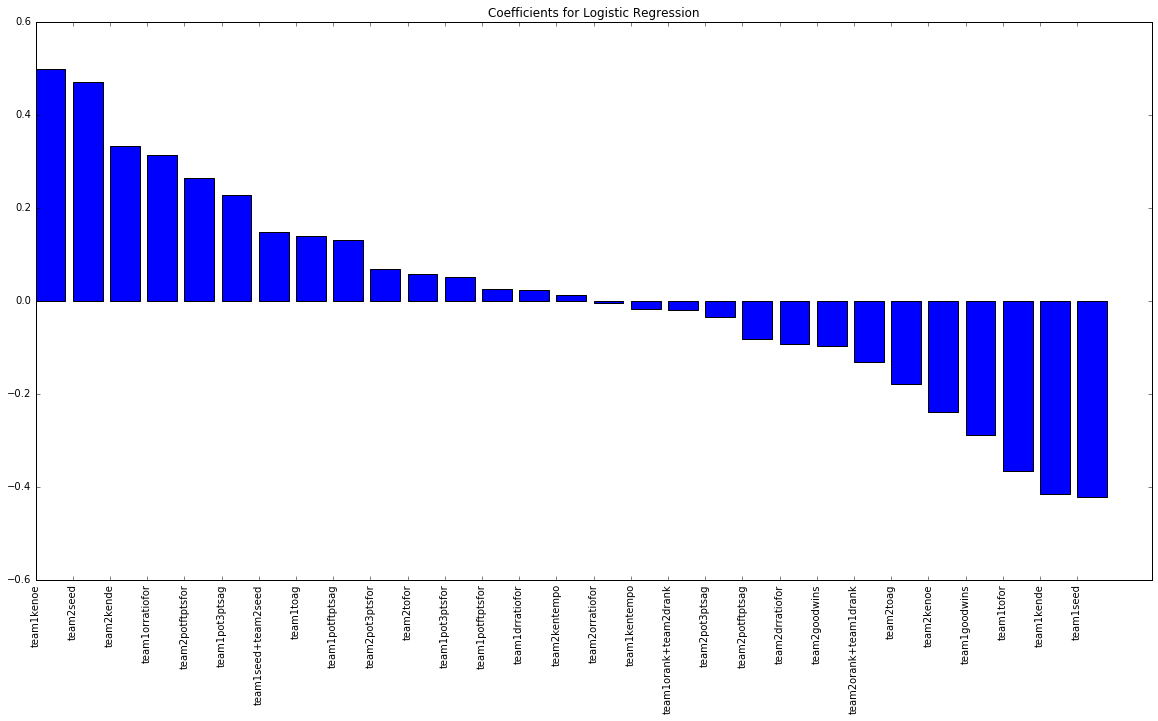

    log_coefs  variables                 LABELS
0    0.197709          0              team2seed
1    0.096181          1             team1kenoe
2    0.082436          2         team1pot3ptsag
3    0.076006          3             team2kende
4    0.062116          4       team2potftptsfor
5    0.049812          5        team2pot3ptsfor
6    0.043697          6        team1potftptsag
7    0.038199          7        team1orratiofor
8    0.035732          8    team1seed+team2seed
9    0.028629          9          team2goodwins
10   0.022740         10          team1kentempo
11   0.019559         11        team2orratiofor
12   0.009785         12       team1potftptsfor
13   0.003904         13              team2toag
14   0.001670         14        team1drratiofor
15  -0.000696         15              team1toag
16  -0.005694         16        team2drratiofor
17  -0.006449         17             team2kenoe
18  -0.009052         18          team2kentempo
19  -0.012790         19         team2po

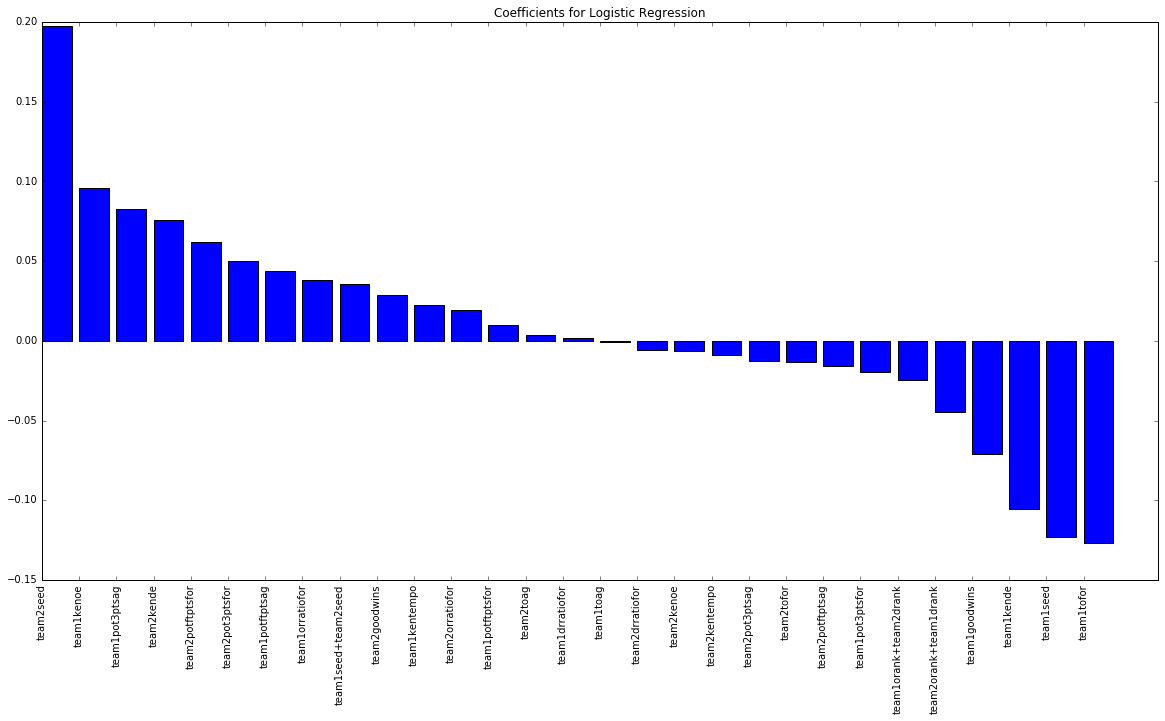

In [75]:
# plot the coefficients for LR and SVM models 

import pylab as plt

def show_coefs(coef_matrix):

    variables = np.array(range(len(coef_matrix)))
    LABELS = predictors_2004_2010.columns.values

    new_df = pd.DataFrame()
    new_df['log_coefs'] = coef_matrix
    new_df['variables'] = variables
    new_df['LABELS'] = LABELS

    new_df = new_df.sort(['log_coefs'], axis = 0, ascending = False)

    new_df = new_df.reset_index()

    new_df = new_df.drop(['index'],axis=1)

    new_df['variables'] = range(len(new_df))
    
    print new_df


    plt.figure(figsize=(20,10))
    plt.bar(new_df['variables'], new_df['log_coefs'])
    plt.title("Coefficients for Logistic Regression")
    plt.xticks(new_df['variables'], new_df['LABELS'], rotation=90)
    # plt.ylim([-0.2,0.3])
    plt.savefig('coefs')
    plt.show()

coef_matrix_1015 = np.concatenate((coef_matrix15,coef_matrix14,coef_matrix13,coef_matrix12,coef_matrix11,coef_matrix10),axis=0)

show_coefs(coef_matrix_1015.mean(axis=0))

coef_matrix_1015_svm = np.concatenate((coef_matrix15_svm,coef_matrix14_svm,coef_matrix13_svm,coef_matrix12_svm,coef_matrix11_svm,coef_matrix10_svm),axis=0)

show_coefs(coef_matrix_1015_svm.mean(axis=0))

In [206]:
# pick the optimal bracket by sending favorite (according to model) forward

print pick_a_bracket(predictions_for_testing15, seeds, bracket_2015, .5, matrix_2015)
print pick_a_bracket(predictions_for_testing14, seeds, bracket_2014, .5, matrix_2014)
print pick_a_bracket(predictions_for_testing13, seeds, bracket_2013, .5, matrix_2013)
#print pick_a_bracket(predictions_for_testing12, seeds, bracket_2012, .5, matrix_2012)
#print pick_a_bracket(predictions_for_testing11, seeds, bracket_2011, .5, matrix_2011)
#print pick_a_bracket(predictions_for_testing10, seeds, bracket_2010, .5, matrix_2010)



['Villanova', 'North Carolina St.', 'Louisville', 'Northern Iowa', 'Providence', 'Oklahoma', 'Michigan St.', 'Virginia', 'Duke', 'San Diego St.', 'Georgetown', 'Utah', 'SMU', 'Iowa St.', 'Iowa', 'Gonzaga', 'Kentucky', 'Cincinnati', 'Maryland', 'West Virginia', 'Butler', 'Notre Dame', 'Wichita St.', 'Kansas', 'Wisconsin', 'Oklahoma St.', 'North Carolina', 'Arkansas', 'Xavier', 'Baylor', 'Ohio St.', 'Arizona']
['Villanova', 'Louisville', 'Oklahoma', 'Virginia', 'Duke', 'Georgetown', 'Iowa St.', 'Gonzaga', 'Kentucky', 'West Virginia', 'Notre Dame', 'Kansas', 'Wisconsin', 'North Carolina', 'Baylor', 'Arizona']
['Villanova', 'Virginia', 'Duke', 'Gonzaga', 'Kentucky', 'Kansas', 'Wisconsin', 'Arizona']
['Villanova', 'Duke', 'Kentucky', 'Wisconsin']
['Villanova', 'Kentucky']
['Villanova']
The amount of correct predictions is 45.0
The score of the bracket was 91
91
['Virginia', 'Memphis', 'Michigan St.', 'Cincinnati', 'North Carolina', 'Iowa St.', 'Connecticut', 'Villanova', 'Florida', 'Pittsbu

In [77]:
# pick the optimal bracket by sending favorite (according to model) forward

print pick_a_bracket(predictions_for_testing15_svm, seeds, bracket_2015, .5, matrix_2015)
print pick_a_bracket(predictions_for_testing14_svm, seeds, bracket_2014, .5, matrix_2014)
print pick_a_bracket(predictions_for_testing13_svm, seeds, bracket_2013, .5, matrix_2013)
#print pick_a_bracket(predictions_for_testing12_svm, seeds, bracket_2012, .5, matrix_2012)
#print pick_a_bracket(predictions_for_testing11_svm, seeds, bracket_2011, .5, matrix_2011)
#print pick_a_bracket(predictions_for_testing10_svm, seeds, bracket_2010, .5, matrix_2010)



['Villanova', 'North Carolina St.', 'Louisville', 'Northern Iowa', 'Providence', 'Oklahoma', 'Michigan St.', 'Virginia', 'Duke', 'San Diego St.', 'Georgetown', 'Utah', 'SMU', 'Iowa St.', 'Iowa', 'Gonzaga', 'Kentucky', 'Cincinnati', 'Maryland', 'West Virginia', 'Butler', 'Notre Dame', 'Wichita St.', 'Kansas', 'Wisconsin', 'Oregon', 'North Carolina', 'Arkansas', 'Xavier', 'Baylor', 'VCU', 'Arizona']
['Villanova', 'Louisville', 'Oklahoma', 'Virginia', 'Duke', 'Georgetown', 'Iowa St.', 'Gonzaga', 'Kentucky', 'Maryland', 'Notre Dame', 'Kansas', 'Wisconsin', 'North Carolina', 'Baylor', 'Arizona']
['Villanova', 'Virginia', 'Duke', 'Gonzaga', 'Kentucky', 'Kansas', 'Wisconsin', 'Arizona']
['Villanova', 'Duke', 'Kentucky', 'Wisconsin']
['Villanova', 'Kentucky']
['Villanova']
The amount of correct predictions is 44.0
The score of the bracket was 89
89
['Virginia', 'Memphis', 'Michigan St.', 'Cincinnati', 'North Carolina', 'Iowa St.', 'Connecticut', 'Villanova', 'Florida', 'Colorado', 'UCLA', 'VCU

In [79]:
# pick the optimal bracket by sending favorite (according to model) forward

print pick_a_bracket(predictions_for_testing15_rf, seeds, bracket_2015, .5, matrix_2015)
print pick_a_bracket(predictions_for_testing14_rf, seeds, bracket_2014, .5, matrix_2014)
print pick_a_bracket(predictions_for_testing13_rf, seeds, bracket_2013, .5, matrix_2013)
#print pick_a_bracket(predictions_for_testing12_rf, seeds, bracket_2012, .5, matrix_2012)
#print pick_a_bracket(predictions_for_testing11_rf, seeds, bracket_2011, .5, matrix_2011)
#print pick_a_bracket(predictions_for_testing10_rf, seeds, bracket_2010, .5, matrix_2010)

['Villanova', 'North Carolina St.', 'Louisville', 'Northern Iowa', 'Providence', 'Oklahoma', 'Michigan St.', 'Virginia', 'Duke', 'San Diego St.', 'Georgetown', 'Utah', 'SMU', 'Iowa St.', 'Iowa', 'Gonzaga', 'Kentucky', 'Cincinnati', 'Maryland', 'West Virginia', 'Butler', 'Notre Dame', 'Wichita St.', 'Kansas', 'Wisconsin', 'Oregon', 'North Carolina', 'Arkansas', 'Xavier', 'Baylor', 'VCU', 'Arizona']
['Villanova', 'Louisville', 'Oklahoma', 'Virginia', 'Duke', 'Georgetown', 'Iowa St.', 'Gonzaga', 'Kentucky', 'Maryland', 'Notre Dame', 'Kansas', 'Wisconsin', 'North Carolina', 'Baylor', 'Arizona']
['Villanova', 'Virginia', 'Duke', 'Gonzaga', 'Kentucky', 'Kansas', 'Wisconsin', 'Arizona']
['Villanova', 'Duke', 'Kentucky', 'Arizona']
['Villanova', 'Kentucky']
['Villanova']
The amount of correct predictions is 43.0
The score of the bracket was 81
81
['Virginia', 'George Washington', 'Michigan St.', 'Cincinnati', 'North Carolina', 'Iowa St.', 'Connecticut', 'Villanova', 'Florida', 'Colorado', 'UCL

In [80]:
# Predicts winners of given round of tournament
#
# Input:
#     pred_matrix - output of make_predictions_log
#     seeds - pre-formatted list of tournament seeds
#     seed_to_name - output of seed_and_name
#     n - number of weighted coin flips 


def pick_winners_binomial(pred_matrix, seeds, seed_to_name, n):
    # counter to track the number of upsets
    upsets = 0
    
    # creates list to hold winners of this round
    winners = []
    
    
    for i in range(0,len(seeds)-1,2):
        
        if(int(seeds[i][-2:]) > int(seeds[i+1][-2:])):
            # adds favorite as winner
            if(np.random.binomial(n,pred_matrix['prediction'][(pred_matrix.iloc[:,1] == seeds[i]) & (pred_matrix.iloc[:,0] == seeds[i+1])].values[0])>(float(n)/2)):            
                winners.append(seeds[i+1])
            # adds underdog as winner
            else:
                winners.append(seeds[i])
                upsets = upsets + 1
        # not exactly sure what this branch is doing
        else:
            if(np.random.binomial(n,pred_matrix['prediction'][(pred_matrix.iloc[:,0] == seeds[i]) & (pred_matrix.iloc[:,1] == seeds[i+1])].values[0])>(float(n)/2)):
                winners.append(seeds[i])
            else:
                winners.append(seeds[i+1])
                upsets = upsets + 1
    
    # create list to hold name of round winners
    winners_name = []
    
    
    for i in range(len(winners)):
        winners_name.append(seed_to_name.iloc[:,1][seed_to_name.iloc[:,0] == winners[i]].values[0])

    #print winners_name
    return winners
           

In [167]:
# pick a bracket by sending winner of "binomial vote" forward 

def pick_a_bracket_binomial(predictions_for_testing, seeds, bracket, matrix_year, n):

    round1winners = pick_winners_binomial(predictions_for_testing, seeds, bracket, n)
    round2winners = pick_winners_binomial(predictions_for_testing, round1winners, bracket, n)
    round3winners = pick_winners_binomial(predictions_for_testing, round2winners, bracket, n)
    round4winners = pick_winners_binomial(predictions_for_testing, round3winners, bracket, n)
    round5winners = pick_winners_binomial(predictions_for_testing, round4winners, bracket, n)
    round6winners = pick_winners_binomial(predictions_for_testing, round5winners, bracket, n)
    
    pred_winners = pd.Series(np.concatenate((round1winners,round2winners,round3winners,round4winners,round5winners,round6winners),axis=0))

    games_played = pd.concat([matrix_year['team1spot'],matrix_year['team2spot'],pd.Series(matrix_year.ix[len(matrix_year)-1,['team1spot']])],axis=0)

    games_won_by_team_2015 = games_played.value_counts()-1

    preds_won_by_team_2015 = pred_winners.value_counts()

    actual_and_prediction_wins = pd.concat([games_won_by_team_2015, preds_won_by_team_2015], axis=1)

    actual_and_prediction_wins = actual_and_prediction_wins.fillna(0)

    right_predictions = 0
    score_bracket = 0
    for i in range(len(actual_and_prediction_wins)):
        right_predictions = right_predictions + np.min(actual_and_prediction_wins.iloc[i,:])
        score_add = 0
        if (np.min(actual_and_prediction_wins.iloc[i,:])>0):
            for j in range(int(np.min(actual_and_prediction_wins.iloc[i,:]))):
                score_add = 2**j + score_add
            score_bracket = score_bracket + score_add

    return score_bracket

In [168]:
# test different vote total on each models max, mean, std for 2015

odd_votes = range(1,25,2)

score_ranges_log = np.zeros((len(odd_votes),50))
score_ranges_svm = np.zeros((len(odd_votes),50))
score_ranges_rf = np.zeros((len(odd_votes),50))



for i in odd_votes:
    for j in range(50):

        score_ranges_log[(i-1)/2,j] = pick_a_bracket_binomial(predictions_for_testing15, seeds, bracket_2015, matrix_2015, i)

for i in odd_votes:
    for j in range(50):

        score_ranges_svm[(i-1)/2,j] = pick_a_bracket_binomial(predictions_for_testing15_svm, seeds, bracket_2015, matrix_2015, i)

for i in odd_votes:
    for j in range(50):

        score_ranges_rf[(i-1)/2,j] = pick_a_bracket_binomial(predictions_for_testing15_rf, seeds, bracket_2015, matrix_2015, i)

        





In [176]:
# display mean, max, std for each model in 2015

send_favorite_maxes =  pd.DataFrame()

send_favorite_maxes['Votes'] = range(1,25,2)
send_favorite_maxes['Log Max'] = score_ranges_log.max(axis=1)
send_favorite_maxes['Log Mean'] = score_ranges_log.mean(axis=1)
send_favorite_maxes['Log Std'] = score_ranges_log.std(axis=1)


send_favorite_maxes['SVM Max'] = score_ranges_svm.max(axis=1)
send_favorite_maxes['SVM Mean'] = score_ranges_svm.mean(axis=1)
send_favorite_maxes['SVM Std'] = score_ranges_svm.std(axis=1)

send_favorite_maxes['RF Max'] = score_ranges_rf.max(axis=1)
send_favorite_maxes['RF Mean'] = score_ranges_rf.mean(axis=1)
send_favorite_maxes['RF Std'] = score_ranges_rf.std(axis=1)

send_favorite_maxes = send_favorite_maxes.round(1)
send_favorite_maxes


,Votes,Log Max,Log Mean,Log Std,SVM Max,SVM Mean,SVM Std,RF Max,RF Mean,RF Std
0,1,150.0,85.2,26.5,149.0,57.6,23.9,122.0,71.4,27.2
1,3,144.0,99.9,22.1,151.0,68.4,24.2,139.0,77.0,26.3
2,5,144.0,97.2,20.5,145.0,81.8,28.2,135.0,88.4,27.1
3,7,153.0,95.8,18.8,146.0,87.7,27.0,138.0,94.8,26.2
4,9,140.0,96.7,17.7,157.0,95.3,26.0,151.0,112.6,27.7
5,11,145.0,102.6,21.4,163.0,89.7,23.7,152.0,104.7,27.5
6,13,139.0,95.8,17.3,149.0,93.3,22.8,150.0,108.9,25.3
7,15,142.0,100.6,20.7,146.0,90.3,17.7,158.0,103.5,28.2
8,17,140.0,95.6,16.6,142.0,87.1,14.3,153.0,104.7,24.9
9,19,145.0,100.9,19.7,145.0,91.4,16.7,148.0,105.4,26.6


[ 150.  144.  144.  153.  140.  145.  139.  142.  140.  145.  139.  139.] [ 149.  151.  145.  146.  157.  163.  149.  146.  142.  145.  141.  142.] [ 122.  139.  135.  138.  151.  152.  150.  158.  153.  148.  154.  154.]


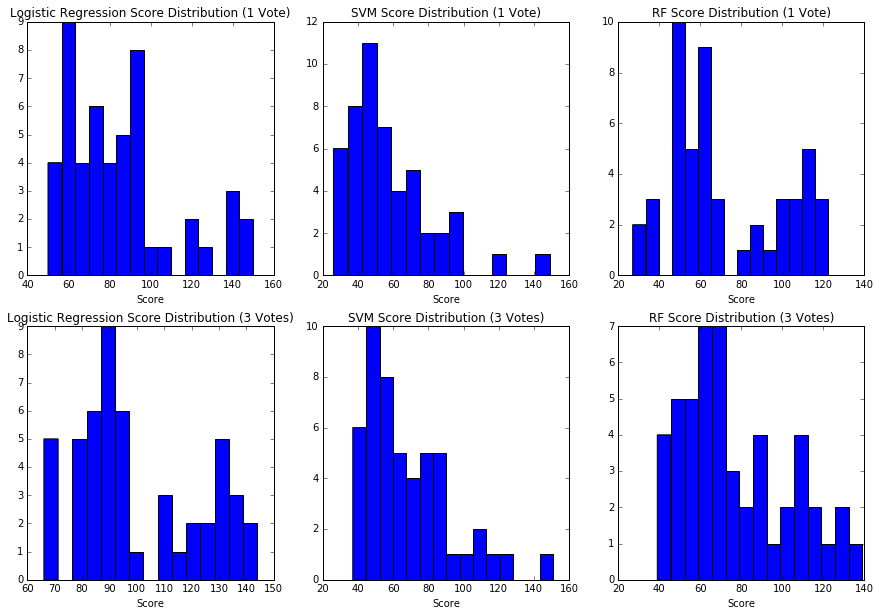

In [179]:
# plot hists of each model's point dist

print score_ranges_log.max(axis=1) , score_ranges_svm.max(axis=1) , score_ranges_rf.max(axis=1) 

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(231)
ax1.hist(score_ranges_log[0,:], bins=15)
ax1.set_title("Logistic Regression Score Distribution (1 Vote)")
ax1.set_xlabel("Score")


ax2 = fig.add_subplot(232)
ax2.hist(score_ranges_svm[0,:], bins=15)
ax2.set_title("SVM Score Distribution (1 Vote)")
ax2.set_xlabel("Score")


ax3 = fig.add_subplot(233)
ax3.hist(score_ranges_rf[0,:], bins=15)
ax3.set_title("RF Score Distribution (1 Vote)")
ax3.set_xlabel("Score")





ax4 = fig.add_subplot(234)
ax4.hist(score_ranges_log[1,:], bins=15)
ax4.set_title("Logistic Regression Score Distribution (3 Votes)")
ax4.set_xlabel("Score")


ax5 = fig.add_subplot(235)
ax5.hist(score_ranges_svm[1,:], bins=15)
ax5.set_title("SVM Score Distribution (3 Votes)")
ax5.set_xlabel("Score")


ax6 = fig.add_subplot(236)
ax6.hist(score_ranges_rf[1,:], bins=15)
ax6.set_title("RF Score Distribution (3 Votes)")
ax6.set_xlabel("Score")

In [193]:
# calculate distributions for each model for 2013-2015

all_brackets = [bracket_2010,bracket_2011,bracket_2012,bracket_2013,bracket_2014,bracket_2015]
all_matrices = [matrix_2010,matrix_2011,matrix_2012,matrix_2013,matrix_2014,matrix_2015]
all_predictions_for_testing_log = [predictions_for_testing10,predictions_for_testing11,predictions_for_testing12,
                               predictions_for_testing13,predictions_for_testing14,predictions_for_testing15]

all_predictions_for_testing_svm = [predictions_for_testing10_svm,predictions_for_testing11_svm,predictions_for_testing12_svm,
                               predictions_for_testing13_svm,predictions_for_testing14_svm,predictions_for_testing15_svm]

all_predictions_for_testing_rf = [predictions_for_testing10_rf,predictions_for_testing11_rf,predictions_for_testing12_rf,
                               predictions_for_testing13_rf,predictions_for_testing14_rf,predictions_for_testing15_rf]



score_ranges_log = np.zeros((3,500))
score_ranges_svm = np.zeros((3,500))
score_ranges_rf = np.zeros((3,500))




for i in range(len(score_ranges_log)):
    for j in range(500):

        score_ranges_log[i,j] = pick_a_bracket_binomial(all_predictions_for_testing_log[i+3], seeds, all_brackets[i+3], all_matrices[i+3], 1)
        score_ranges_svm[i,j] = pick_a_bracket_binomial(all_predictions_for_testing_svm[i+3], seeds, all_brackets[i+3], all_matrices[i+3], 1)
        score_ranges_rf[i,j] = pick_a_bracket_binomial(all_predictions_for_testing_rf[i+3], seeds, all_brackets[i+3], all_matrices[i+3], 1)


print score_ranges_log

print score_ranges_svm

print score_ranges_rf

[[  76.   69.   80. ...,   81.   61.  107.]
 [  50.   55.   40. ...,   63.   62.   60.]
 [ 121.  103.  125. ...,   82.   77.  103.]]
[[ 104.   48.   39. ...,   36.   52.   85.]
 [  57.   46.   50. ...,   54.   50.   40.]
 [  22.  106.   57. ...,   50.   29.   65.]]
[[  67.   48.   33. ...,   40.   53.   44.]
 [  49.   50.   48. ...,   41.   50.   28.]
 [  52.  104.   50. ...,   37.   60.   40.]]


In [194]:
# display summary stats for each model for 2013-2015

send_favorite_maxes =  pd.DataFrame()

send_favorite_maxes['Year'] = [2013,2014,2015]
send_favorite_maxes['Log Max'] = score_ranges_log.max(axis=1)
send_favorite_maxes['Log Mean'] = score_ranges_log.mean(axis=1)
send_favorite_maxes['Log Std'] = score_ranges_log.std(axis=1)


send_favorite_maxes['SVM Max'] = score_ranges_svm.max(axis=1)
send_favorite_maxes['SVM Mean'] = score_ranges_svm.mean(axis=1)
send_favorite_maxes['SVM Std'] = score_ranges_svm.std(axis=1)

send_favorite_maxes['RF Max'] = score_ranges_rf.max(axis=1)
send_favorite_maxes['RF Mean'] = score_ranges_rf.mean(axis=1)
send_favorite_maxes['RF Std'] = score_ranges_rf.std(axis=1)

send_favorite_maxes = send_favorite_maxes.round(1)
send_favorite_maxes


,Year,Log Max,Log Mean,Log Std,SVM Max,SVM Mean,SVM Std,RF Max,RF Mean,RF Std
0,2013,140.0,83.8,20.4,131.0,52.8,22.1,130.0,63.0,22.5
1,2014,75.0,57.6,7.6,110.0,46.7,12.5,99.0,44.3,10.0
2,2015,162.0,88.3,25.5,146.0,58.0,23.7,151.0,66.8,26.8


Generally speaking, the Logistic Regression model does better in terms of mean and max bracket score than do the other two models. So the final model to predict 2016 is the logistic regression model.

**2016 Predictions**

In [133]:
def matchups_matrix_2016(info2016):
    # creates dataframe to hold all possible seed matchups
    preds_all_games = pd.DataFrame(np.zeros((64**2,2)))

    # creates counter for indexing
    count = 0
    
    # inserts all possible combinations of seeds into preds_all_games
    for i in range(len(info2016)):
        for j in range(len(info2016)):
            preds_all_games.ix[count,0] = info2016['team1spot'].iloc[i]
            preds_all_games.ix[count,1] = info2016['team1spot'].iloc[j]
            count = count + 1
    
    # creates two new dataframes to hold predictors for each team
    favorites = pd.DataFrame(np.zeros((64**2,13)))
    underdogs = pd.DataFrame(np.zeros((64**2,13)))

    # retrieves predictors for the favorites and underdogs
    for i in range(0,64**2):
        favorites.iloc[i,:] = pd.Series(info2016.iloc[:,range(15)][info2016['team1spot']==preds_all_games.iloc[i,0]].values[0])
        underdogs.iloc[i,:] = pd.Series(info2016.iloc[:,range(15)][info2016['team1spot']==preds_all_games.iloc[i,1]].values[0])
    
    
    interaction_terms = pd.DataFrame(np.zeros((64**2,3)))
    for i in range(0,64**2):
        interaction_terms.iloc[i,0] = favorites.iloc[i,9] * underdogs.iloc[i,10]
        interaction_terms.iloc[i,1] = underdogs.iloc[i,9] * favorites.iloc[i,10]
        #interaction_terms.iloc[i,2] =  favorites.iloc[i,13] * underdogs.iloc[i,13]    
        interaction_terms.iloc[i,2] = favorites.iloc[i,11] * favorites.iloc[i,11]
    # concatenates all dataframes together
    preds_all_games_final = pd.concat([preds_all_games, favorites, underdogs,
                                            interaction_terms], axis=1)
    
    # renames columns
    preds_all_games_final.columns = ["favorite", "underdog",'team1tofor', 'team1drratiofor', 'team1orratiofor', 
'team1pot3ptsfor',
 'team1potftptsfor', 'team1toag' ,
 'team1pot3ptsag' ,'team1potftptsag', 'team1kentempo' ,'team1drank',
 'team1orank' ,
 'team1seed', 
'team1goodwins', 'team2tofor',
 'team2drratiofor', 'team2orratiofor', 'team2pot3ptsfor' ,'team2potftptsfor',
 'team2toag' ,'team2pot3ptsag',
 'team2potftptsag', 'team2kentempo' ,'team2drank', 'team2orank', 
 'team2seed',
 'team2goodwins' , 'team1orank+team2drank',
 'team2orank+team1drank', 'team1seed+team2seed']
    
    return preds_all_games_final

In [134]:
info2016 = pd.read_csv("info2016.csv")

matchups_2016 = matchups_matrix_2016(info2016)

In [135]:
predictions_for_testing16, coef_matrix16 = make_predictions_log(matchups_2016.iloc[:,range(29+2)], predictors_2009_2015, response_2009_2015, .1)
predictions_for_testing16_svm, coef_matrix16_svm = make_predictions_svm(matchups_2016.iloc[:,range(29+2)], predictors_2009_2015, response_2009_2015, 10**-7)

predictions_for_testing16_rf, importance16 = make_predictions_rf(matchups_2016.iloc[:,range(29+2)], predictors_2009_2015, response_2009_2015, 4, 6)

In [136]:
bracket_2016 = seed_and_name(seeds, info2016)

In [137]:
team_wins_2016 = pd.Series(['W01','W01','W01','W01','W01','W09','W05','W05','W04','W06','W06','W06','W14','W07','W07','W02',
                 'X01','X01','X01','X10','X10','X10','X10','X11','X11','X12','X03','X04','X04','X15','X09',
                 'Y02','Y02','Y02','Y02','Y02','Y02','Y01','Y01','Y01','Y05','Y05','Y13','Y11','Y07','Y03','Y03','Y09',
                 'Z01','Z01','Z01','Z02','Z02','Z02','Z02','Y03','Y03','Y04','Y04','Y08','Y10','Y11','Y12' ])

In [213]:
def pick_a_bracket_binomial_2016(predictions_for_testing, seeds, bracket, n, team_wins_2016):

    round1winners = pick_winners_binomial(predictions_for_testing, seeds, bracket, n)
    round2winners = pick_winners_binomial(predictions_for_testing, round1winners, bracket, n)
    round3winners = pick_winners_binomial(predictions_for_testing, round2winners, bracket, n)
    round4winners = pick_winners_binomial(predictions_for_testing, round3winners, bracket, n)
    round5winners = pick_winners_binomial(predictions_for_testing, round4winners, bracket, n)
    round6winners = pick_winners_binomial(predictions_for_testing, round5winners, bracket, n)
    
    pred_winners = pd.Series(np.concatenate((round1winners,round2winners,round3winners,round4winners,round5winners,round6winners),axis=0))
                        
    games_won_by_team_2016 = team_wins_2016.value_counts()

    preds_won_by_team_2016 = pred_winners.value_counts()

    actual_and_prediction_wins = pd.concat([games_won_by_team_2016, preds_won_by_team_2016], axis=1)

    actual_and_prediction_wins = actual_and_prediction_wins.fillna(0)

    right_predictions = 0
    score_bracket = 0
    for i in range(len(actual_and_prediction_wins)):
        right_predictions = right_predictions + np.min(actual_and_prediction_wins.iloc[i,:])
        score_add = 0
        if (np.min(actual_and_prediction_wins.iloc[i,:])>0):
            for j in range(int(np.min(actual_and_prediction_wins.iloc[i,:]))):
                score_add = 2**j + score_add
            score_bracket = score_bracket + score_add

    return score_bracket

score_ranges_log = np.zeros((1,500))
score_ranges_svm = np.zeros((1,500))
score_ranges_rf = np.zeros((1,500))





for j in range(500):

    score_ranges_log[0,j] = pick_a_bracket_binomial_2016(predictions_for_testing16, seeds, bracket_2016, 1, team_wins_2016)
    score_ranges_svm[0,j] = pick_a_bracket_binomial_2016(predictions_for_testing16_svm, seeds, bracket_2016, 1, team_wins_2016)
    score_ranges_rf[0,j] = pick_a_bracket_binomial_2016(predictions_for_testing16_rf, seeds, bracket_2016,  1, team_wins_2016)



(0, 160)

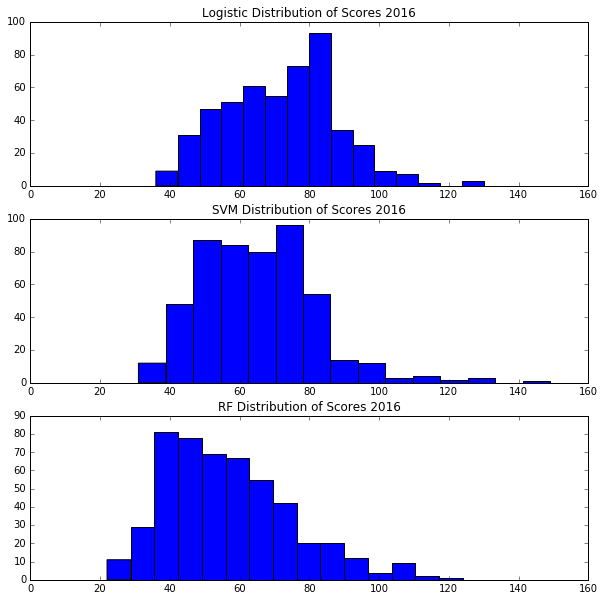

In [214]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(311)
ax1.hist(score_ranges_log[0,:], bins=15)
ax1.set_title("Logistic Distribution of Scores 2016")
ax1.set_xlim([0,160])


ax2 = fig.add_subplot(312)
ax2.hist(score_ranges_svm[0,:], bins=15)
ax2.set_title("SVM Distribution of Scores 2016")
ax2.set_xlim([0,160])


ax3 = fig.add_subplot(313)
ax3.hist(score_ranges_rf[0,:], bins=15)
ax3.set_title("RF Distribution of Scores 2016")
ax3.set_xlim([0,160])

In [215]:
print score_ranges_rf.max(axis=1)
print score_ranges_log.max(axis=1)
print score_ranges_svm.max(axis=1)

[ 124.]
[ 130.]
[ 149.]


In [218]:
binomial_2016 =  pd.DataFrame()

binomial_2016['Log Max'] = score_ranges_log.max(axis=1)
binomial_2016['Log Mean'] = score_ranges_log.mean(axis=1)
binomial_2016['Log Std'] = score_ranges_log.std(axis=1)


binomial_2016['SVM Max'] = score_ranges_svm.max(axis=1)
binomial_2016['SVM Mean'] = score_ranges_svm.mean(axis=1)
binomial_2016['SVM Std'] = score_ranges_svm.std(axis=1)

binomial_2016['RF Max'] = score_ranges_rf.max(axis=1)
binomial_2016['RF Mean'] = score_ranges_rf.mean(axis=1)
binomial_2016['RF Std'] = score_ranges_rf.std(axis=1)

binomial_2016 = binomial_2016.round(1)
binomial_2016

,Log Max,Log Mean,Log Std,SVM Max,SVM Mean,SVM Std,RF Max,RF Mean,RF Std
0,130.0,71.9,16.2,149.0,65.5,16.9,124.0,57.0,18.1


As was suggested above, the logistic regression model was the best in terms of getting a very high bracket score. We want to create a model that does very well occassionally rather than doing above average every year, so we care more about the max of the 